In [ ]:
import pandas as pd
import re
import numpy as np
import keras
import pickle
import matplotlib.pyplot as plt
import nltk
from keras.preprocessing.text import Tokenizer
from keras.layers import Dropout, Dense, LSTM, Bidirectional, Embedding, InputLayer
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/dataset.csv')

In [ ]:
dataset = dataset.sample(frac=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


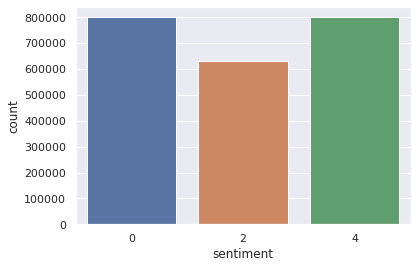

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(dataset.sentiment)

In [ ]:
tweets_data = np.array(dataset['text'])
label_data = np.array(dataset['sentiment'])

In [ ]:
def tokenize(X):
  treebank = nltk.tokenize.TreebankWordTokenizer()
  X_tokenized=[treebank.tokenize(sentence) for sentence in X]  
  return X_tokenized

In [ ]:
def remove_noise(tweet_tokens):
    # remove hyperlinks, special characters, emojis, punctuations
    
    for i in range(len(tweet_tokens)):
        tweet_tokens[i] = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                           '(?:%[0-9a-fA-F][0-9a-fA-F]))*', '', tweet_tokens[i])
        # Remove twitter handles
        tweet_tokens[i] = re.sub("(@[A-Za-z0-9_]*)","", tweet_tokens[i])
        # make lower
        tweet_tokens[i] = tweet_tokens[i].lower()
        tweet_tokens[i] = re.sub('\brt\b', '', tweet_tokens[i])
        tweet_tokens[i] = re.sub('[^\w\s]', '', tweet_tokens[i])
    return tweet_tokens

In [ ]:
def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return 'a'
        elif treebank_tag.startswith('V'):
            return 'v'
        elif treebank_tag.startswith('N'):
            return 'n'
        elif treebank_tag.startswith('R'):
            return 'r'
        else:
            return None


def lemmatize(X):
  """
  Lemmatize words using corresponding POS tag
  """

  lemmatizer = nltk.stem.WordNetLemmatizer()
  
  X_pos = []
  X_lemmatized = []

  for sentence in X :

    temp = nltk.pos_tag(sentence)
    X_pos.append(temp)  

  for sentence in X_pos :

    temp = [ lemmatizer.lemmatize(word[0],pos=get_wordnet_pos(word[1])) for word in sentence]
    X_lemmatized.append(temp)  

  return X_lemmatized

In [ ]:
tweets_cleaned = remove_noise(tweets_data)

In [ ]:
tokenized_td = tokenize(tweets_cleaned)

In [ ]:
lemmatized_td = lemmatize(tokenized_td)

In [ ]:
clean_td = []

for sentence in lemmatized_td:

  temp = " ".join(sentence)
  clean_td.append(temp)

In [ ]:
max_vocab = 400000

In [ ]:
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(clean_td)

In [ ]:
with open('/content/drive/MyDrive/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

In [ ]:
clean_vectorized=tokenizer.texts_to_sequences(clean_td)

In [ ]:
max_length = 30

In [ ]:
clean_pad = keras.preprocessing.sequence.pad_sequences(clean_vectorized,max_length,padding='post',
                                                         truncating='post')

print(clean_pad.shape)

(2229566, 30)


In [ ]:
# Visualize pre-processed data

index  = 306  # index in range [0,1599999]

print('\nOriginal :')
print(tweets_data[index])
print('\nTokenized :')
print(tokenized_td[index])
print('\nLemmatized :')
print(lemmatized_td[index])
print('\nClean :')
print(clean_td[index])
print('\nVectorized :')
print(clean_vectorized[index])
print('\nPadded :')
print(clean_pad[index])


Original :
shop morespend lesskwesi broni blw out sale friday 9am at sunnyfm yardcall now 0242132272

Tokenized :
['shop', 'morespend', 'lesskwesi', 'broni', 'blw', 'out', 'sale', 'friday', '9am', 'at', 'sunnyfm', 'yardcall', 'now', '0242132272']

Lemmatized :
['shop', 'morespend', 'lesskwesi', 'broni', 'blw', 'out', 'sale', 'friday', '9am', 'at', 'sunnyfm', 'yardcall', 'now', '0242132272']

Clean :
shop morespend lesskwesi broni blw out sale friday 9am at sunnyfm yardcall now 0242132272

Vectorized :
[410, 20339, 20340, 13849, 13729, 32, 409, 265, 3656, 19, 12614, 14131, 29, 13141]

Padded :
[  410 20339 20340 13849 13729    32   409   265  3656    19 12614 14131
    29 13141     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [ ]:
# (0 = negative, 2 = neutral, 4 = positive) ==> (0 = negative, 1 = neutral, 2 = positive)
for idx in range(len(label_data)):
    if label_data[idx] == 2:
        label_data[idx] = 1
    elif label_data[idx] == 4:
        label_data[idx] = 2

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(clean_pad,label_data.reshape(label_data.shape[0],1),test_size=0.30)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1560696, 30)
(668870, 30)
(1560696, 1)
(668870, 1)


In [ ]:
# pickle

with open('fsacd_x_train.pickle', 'wb') as handle:
    pickle.dump(X_train, handle)

with open('fsacd_x_test.pickle', 'wb') as handle:
    pickle.dump(X_test, handle)
    
with open('fsacd_y_train.pickle', 'wb') as handle:
    pickle.dump(Y_train, handle)
    
with open('fsacd_y_test.pickle', 'wb') as handle:
    pickle.dump(Y_test, handle)

In [ ]:
# Load Pre-trained Word embeddings
embedding_path = '/content/drive/MyDrive/glove.6B.300d.txt'

embeddings_index = dict()
f = open(embedding_path, encoding='utf8')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

# Create Word Embedding Matrix

embedding_matrix = np.zeros((max_vocab, 300))
for i in range(1,max_vocab):
	embedding_vector = embeddings_index.get(tokenizer.index_word[i])
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
with open('/content/drive/MyDrive/embmat.pickle', 'wb') as handle:
    pickle.dump(embedding_matrix, handle)